# ***Step 1: Import libraries***

In [ ]:
# For saving and loading models
import torch
import torch.nn as nn
import torch.optim as optim

#

# ***Step 2: Loading trained model (FP32)***


In [ ]:
class LSTMModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.encoder(input)
        output, hidden = self.rnn(emb, hidden)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

        net = Net()
        print(net)



# ***Step 3: Apply Dynamic Quantization***

### ***Method 1:***

In [ ]:
import torch
from torch import nn
# toy model
m = nn.Sequential(
nn.Conv2d(2, 64, (8,)),
nn.ReLU(),
nn.Linear(16,10),
nn.LSTM(10, 10))
m.eval()
## EAGER MODE
from torch.quantization import quantize_dynamic
model_quantized = quantize_dynamic(
model=m, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)
## FX MODE
from torch.quantization import quantize_fx
qconfig_dict = {"": torch.quantization.default_dynamic_qconfig} # An empty key denotes the default applied to all modules
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict)
model_quantized = quantize_fx.convert_fx(model_prepared)


/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/_reference/modules/utils.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weight_qparams["scale"], dtype=torch.float, device=device))
/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/_reference/modules/utils.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(weight_qparams["zero_point"], dtype=zero_point_dtype, device=device))
/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/_reference/modules/rnn.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tenso

### ***Method 2:***

In [ ]:
ntokens = 10

float_model = LSTMModel(
    ntoken = ntokens,
    ninp = 512,
    nhid = 256,
    nlayers = 5,
)

float_model.eval()

qmodel = torch.quantization.quantize_dynamic(
    float_model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)

print(qmodel)
print(float_model)


LSTMModel(
  (encoder): Embedding(10, 512)
  (rnn): DynamicQuantizedLSTM(512, 256, num_layers=5, dropout=0.5)
  (decoder): DynamicQuantizedLinear(in_features=256, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)
LSTMModel(
  (encoder): Embedding(10, 512)
  (rnn): LSTM(512, 256, num_layers=5, dropout=0.5)
  (decoder): Linear(in_features=256, out_features=10, bias=True)
)


### ***Method 3:***

In [ ]:
import torch

# define a floating point model
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.fc = torch.nn.Linear(4, 4)

    def forward(self, x):
        x = self.fc(x)
        return x

# create a model instance
model_fp32 = LSTM()
# create a quantized model instance
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,  # the original model
    {torch.nn.Linear},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# run the model
input_fp32 = torch.randn(4, 4, 4, 4)
res = model_int8(input_fp32)
print(res)


tensor([[[[-3.8906e-01,  1.0008e+00, -4.9139e-01,  9.6216e-02],
          [ 5.3048e-01, -4.6213e-01, -3.0216e-01, -2.6940e-01],
          [ 3.2085e-02,  2.7063e-01, -1.7090e-01,  6.6692e-02],
          [ 7.2063e-01, -7.4024e-01,  8.6098e-02, -4.3146e-02]],

         [[-3.1089e-01,  9.1191e-01,  4.3488e-01,  8.1107e-01],
          [-1.1708e+00,  6.2431e-01, -2.1863e-01, -5.8193e-01],
          [-5.3913e-01,  1.0334e+00, -1.7672e-01,  2.6036e-01],
          [-4.2378e-01, -2.0880e-01, -3.2847e-01, -7.9610e-01]],

         [[-3.1854e-01,  5.8622e-01,  6.1647e-01,  6.8212e-01],
          [-5.7691e-01,  1.8772e-01, -6.8704e-01, -8.6126e-01],
          [ 2.0525e-01, -1.8248e-01,  1.2539e-04, -5.3854e-02],
          [-1.2563e-01,  4.7975e-01, -2.3469e-01,  8.6578e-02]],

         [[-3.1792e-01,  2.3774e-01, -2.6192e-01, -2.9693e-01],
          [-1.0606e+00,  1.3101e+00, -4.7578e-01, -1.4855e-01],
          [-9.9286e-01,  8.8606e-01,  5.2407e-01,  3.5337e-01],
          [-5.4347e-02, -5.6279e-0

### ***Method 4:***

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

In [ ]:
class ModuleLSTM(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
    super().__init__()
    self.lstm = nn.LSTM(
        input_size  = n_features,
        hidden_size = n_hidden,
        num_layers  = n_layers,
        batch_first = True,
        dropout     = 0.75
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    self.lstm.flatten_parameters()
    _, (hidden, _) = self.lstm(x)
    out = hidden[-1]
    return self.classifier(out)


batch_size = 64
seq_len = 5
nb_features = 1
model = ModuleLSTM(nb_features, n_classes=10)
x = torch.randn(batch_size, seq_len, nb_features)
out = model(x)
print(out)


tensor([[-4.6864e-02,  6.6820e-02,  3.5481e-02, -6.3877e-02,  7.2465e-02,
         -5.3806e-02, -8.2636e-03, -1.4740e-02,  1.6877e-02, -2.5118e-02],
        [-3.4254e-02,  6.2100e-02,  3.1512e-02, -6.5204e-02,  7.9455e-02,
         -5.4938e-02,  5.3341e-03, -4.5955e-03,  1.7325e-02, -1.8402e-02],
        [-4.0693e-02,  6.8042e-02,  3.5688e-02, -6.6112e-02,  7.5580e-02,
         -5.3583e-02, -7.8248e-03, -9.1520e-03,  6.5269e-03, -1.8914e-02],
        [-3.4260e-02,  5.2263e-02,  2.9991e-02, -6.3469e-02,  7.5474e-02,
         -5.0625e-02,  5.8851e-03, -7.6323e-03,  1.4697e-02, -2.3001e-02],
        [-4.0627e-02,  6.0156e-02,  4.1585e-02, -6.5225e-02,  7.1640e-02,
         -5.6873e-02,  5.9120e-03,  3.6811e-03,  1.4526e-02, -2.5722e-02],
        [-4.9704e-02,  6.4464e-02,  3.8494e-02, -6.5520e-02,  7.0493e-02,
         -5.3537e-02, -4.6180e-03, -1.0302e-02,  2.5172e-03, -1.9891e-02],
        [-3.9857e-02,  6.2457e-02,  3.7267e-02, -6.7501e-02,  7.5593e-02,
         -5.0132e-02,  3.0420e-0

# ***Step 4: Minmax observer/ Histogram Calibrator etc***

In [ ]:
from torch.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver
C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = [normal.sample((C, L)), normal.sample((C, L))]
print(inputs)

[tensor([[ 0.9032,  0.2365, -0.1277, -1.1493],
        [-0.3737,  1.2521,  1.8214,  0.4370],
        [ 0.1342,  0.9068,  1.6696, -0.7285]]), tensor([[ 0.6434, -1.4803, -0.1149, -0.2925],
        [ 3.3879,  1.4617, -1.3710,  1.7479],
        [ 0.7907, -1.4027,  0.9413,  1.4478]])]


In [ ]:
observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
    for x in inputs: obs(x)
print(obs.__class__.__name__, obs.calculate_qparams())

HistogramObserver (tensor([0.0103]), tensor([73], dtype=torch.int32))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



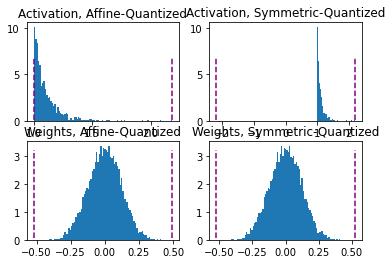

In [ ]:
act = torch.distributions.pareto.Pareto(1, 10).sample((1,1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

def get_symmetric_range(x):
   beta = torch.max(x.max(), x.min().abs())
   return -beta.item(), beta.item()

def get_affine_range(x):
    return x.min().item(), x.max().item()

def plot(plt, data, scheme):
     boundaries = get_affine_range(data) if scheme == 'affine' else get_symmetric_range(data)
     a, _, _ = plt.hist(data, density=True, bins=100)
     ymin, ymax = np.quantile(a[a>0], [0.25, 0.95])
     plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

fig, axs = plt.subplots(2,2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")
plt.show()

In [ ]:
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
    obs = MovingAverageMinMaxObserver(qscheme=qscheme)
    for x in inputs: obs(x)
    print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

Qscheme: torch.per_tensor_affine | (tensor([0.0117]), tensor([98], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([0.0144]), tensor([128]))


In [ ]:
from torch.quantization.observer import MovingAveragePerChannelMinMaxObserver
obs = MovingAveragePerChannelMinMaxObserver(ch_axis=0) # calculate qparams for all `C` channels separately
for x in inputs: obs(x)
print(obs.calculate_qparams())

(tensor([0.0081, 0.0087, 0.0094]), tensor([143,  44,  78], dtype=torch.int32))


# ***Step 5 : MSE/ SQNR Calculation***

## ***Method 1:***

In [ ]:
# extract from https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html
import torch.quantization._numeric_suite as ns

def SQNR(x, y):
    # Higher is better
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

wt_compare_dict = ns.compare_weights(fp32_model.state_dict(), int8_model.state_dict())
for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

act_compare_dict = ns.compare_model_outputs(fp32_model, int8_model, input_data)
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))


# ***Step 6: Inferences at Int8_Model Size***

In [ ]:
# imports
import os
from io import open
import time

import torch
import torch.nn as nn
import torch.nn.functional as F



In [ ]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

# ***Step 7: Inference Time EValuation***

In [ ]:
torch.set_num_threads(1)

def time_model_evaluation(model, test_data):
    s = time.time()
    loss = evaluate(model, test_data)
    elapsed = time.time() - s
    print('''loss: {0:.3f}\nelapsed time (seconds): {1:.1f}'''.format(loss, elapsed))

time_model_evaluation(model, test_data)
time_model_evaluation(quantized_model, test_data)